본 코드는 텐서플로우 심층 합성곱 생성적 적대 신경망 튜토리얼을 기반으로 만들었습니다.

# GAN (Generative Adversarial Network) 
GAN은 위조지폐범에 해당하는 생성자(Generator)와 경찰에 해당하는 구분자(Discriminator)를 경쟁적으로 학습시킨다. 생성자의 목적은 그럴듯한 가짜 데이터를 만들어서 구분자를 속이는 것이며, 구분자의 목적은 생성자가 만든 가짜 데이터와 진짜 데이터를 구분하는 것이다. 이 둘을 함께 학습시키면서 진짜와 구분할 수 없는 가짜를 만들어내는 생성자를 얻을 수 있다. 이것이 GAN의 핵심적인 아이디어인 적대적 학습(Adversarial Training)이다. [[1]](https://dreamgonfly.github.io/blog/gan-explained/)


![image](https://img3.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/24/learningspoons/20210524032430985qkpg.png)

[그림1](https://img3.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/24/learningspoons/20210524032430985qkpg.png) 

---

GAN은 훈련과정 동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 되고, 감별자는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 감별자가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다. [[2]](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)
![image](https://tensorflow.org/tutorials/generative/images/gan2.png?hl=ko)

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 데이터셋 로드 

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [4]:
BATCH_SIZE = 256

In [5]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

#모델 (DCGAN)

![image](https://mblogthumb-phinf.pstatic.net/MjAxOTA5MDVfMjQ2/MDAxNTY3Njc3NjMwMTk1.LPzZsZ9wnhnkVXEo9QZYuDHE36Zg_8NqPjg-ga2wsQkg.YGs3MiFHX7rZjsDAs2uVugDKS9p1BbdkKxHql5DzXGgg.PNG.intelliz/dcgan.png?type=w800)

[그림](https://mblogthumb-phinf.pstatic.net/MjAxOTA5MDVfMjQ2/MDAxNTY3Njc3NjMwMTk1.LPzZsZ9wnhnkVXEo9QZYuDHE36Zg_8NqPjg-ga2wsQkg.YGs3MiFHX7rZjsDAs2uVugDKS9p1BbdkKxHql5DzXGgg.PNG.intelliz/dcgan.png?type=w800)


## 생성자 
생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, tf.keras.layers.Conv2DTranspose (업샘플링) 층을 이용합니다. 처음 Dense층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 tf.keras.layers.LeakyReLU을 사용하고 있음을 주목합시다.

### TransposConv

![image](https://user-images.githubusercontent.com/50395556/81533378-0f10d300-93a1-11ea-9e69-e775b3c4bdd4.png)
![image](https://user-images.githubusercontent.com/50395556/81541105-9401e980-93ad-11ea-87a1-a7676fbd8314.png)

---

## 판별자
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

In [6]:
def Generator():
    generator = tf.keras.Sequential() 
    
    generator.add(tf.keras.Input(shape=(100,)))
    generator.add(layers.Dense(7 * 7 * 256))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU()) 

    generator.add(layers.Reshape((7, 7, 256)))
    generator.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding="same"))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))

    generator.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same"))

    return generator 

In [7]:
def Discriminator(): 
    discriminator = tf.keras.Sequential()

    discriminator.add(tf.keras.Input(shape=(28, 28, 1)))
    discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, padding="same"))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Dropout(0.3)) 

    discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    discriminator.add(layers.LeakyReLU(alpha=0.2))
    discriminator.add(layers.Dropout(0.3)) 

    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1))

    return discriminator 

In [8]:
generator = Generator()
discriminator = Discriminator() 

# 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다.

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 판별자 손실함수
이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 생성자 손실함수
생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer
감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 훈련 루프 정의하기


In [13]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # 노이즈 이미지 생성 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # 이미지 생성 

      real_output = discriminator(images, training=True) # 실제 이미지
      fake_output = discriminator(generated_images, training=True) # 생성된 이미지 

      gen_loss = generator_loss(fake_output) # 생성자 손실함수 
      disc_loss = discriminator_loss(real_output, fake_output) # 판별자 손실함수 

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # 생성자 그라디언트 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # 판별자 그라디언트 계산 

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # 생성자 그라디언트 업데이트
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # 판별자 그라디언트 업데이트 

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# 이미지 생성 및 저장

In [16]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#모델 훈련
위에 정의된 train() 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있습니다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.) 훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요될 것입니다.

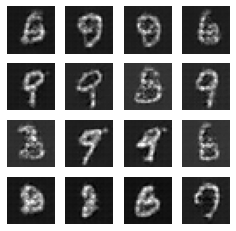

CPU times: user 5min 2s, sys: 32.8 s, total: 5min 35s
Wall time: 20min 57s


In [17]:
%%time
train(train_dataset, EPOCHS)

# 결과

![image](https://tensorflow.org/images/gan/dcgan.gif?hl=ko)

[그림](https://tensorflow.org/images/gan/dcgan.gif?hl=ko)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

  for i in range(50):
      plt.subplot(10, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>